<a href="https://colab.research.google.com/github/hidingbehindrainbows/Samsung-Prism/blob/main/finalMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Everything - All the libraries

In [1]:
import re
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from keras import layers
import os

In [2]:
# Dataset size = 1488
IMAGE_SIZE = 256
BATCH_SIZE = 32 #We are keeping 32 images in each batch.
MAX_TRAIN_IMAGES = 1376 #43 batches for Training.
# maybe we can use cross validation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
folder_path = '/content/drive/My Drive/Samsung_Prism/'
os.chdir(folder_path)

Sort the Low Light Images

Check If image is in the correct format

In [6]:
extraVal = 2
supported_formats = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

def is_supported_image(filename):
    return any(filename.lower().endswith(ext) for ext in supported_formats)

# Filter files based on supported formats
train_low_light_images = sorted([f for f in glob("./All Datasets/Dark And Bright Dataset/dark/*") if is_supported_image(f)],
                                key=lambda x: int(re.search(r'\d+', x).group()))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted([f for f in glob("./All Datasets/Dark And Bright Dataset/dark/*") if is_supported_image(f)],
                              key=lambda x: int(re.search(r'\d+', x).group()))[MAX_TRAIN_IMAGES:MAX_TRAIN_IMAGES + (BATCH_SIZE * extraVal)]

test_low_light_images = sorted([f for f in glob("./All Datasets/Dark And Bright Dataset/dark/*") if is_supported_image(f)],
                               key=lambda x: int(re.search(r'\d+', x).group()))[MAX_TRAIN_IMAGES + (BATCH_SIZE * extraVal):]

Check for corrupted images

In [7]:
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Check if it's a valid image
        return True
    except (IOError, SyntaxError):
        return False

train_low_light_images = [f for f in train_low_light_images if is_valid_image(f)]
val_low_light_images = [f for f in val_low_light_images if is_valid_image(f)]
test_low_light_images = [f for f in test_low_light_images if is_valid_image(f)]

Yeah so to add an extra image, just add an extra integer here in the test_low_light_images. So that only your image is outputed in the end part. Understood?

In [8]:
def loadData(imagePath):
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(images = image, size = [IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    return image

def dataGenerator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
    dataset = dataset.map(loadData, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)
    return dataset

In [9]:
train_dataset = dataGenerator(train_low_light_images)
val_dataset = dataGenerator(val_low_light_images)

print(f"Train Dataset: {train_dataset}")
print(f"Validation Dataset: {val_dataset}")

Train Dataset: <_BatchDataset element_spec=TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset: <_BatchDataset element_spec=TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None)>


In [23]:
def buildingOurNeuralNetwork():
    """Six Convolutional 2D Layers, 3 Concatenation Layers and 1 Finalizing Convolutional layer with 24 filters"""
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(32, (3,3), strides = (1,1), activation="relu", padding="same")(input_img)
    conv2 = layers.Conv2D(32, (3,3), strides = (1,1), activation="relu", padding="same")(conv1)
    conv3 = layers.Conv2D(32, (3,3), strides = (1,1), activation="relu", padding="same")(conv2)
    conv4 = layers.Conv2D(32, (3,3), strides = (1,1), activation="relu", padding="same")(conv3)
    int_conv1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(32, (3,3), strides = (1,1), activation="relu", padding="same")(int_conv1)
    int_conv2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(32, (3,3), strides = (1,1), activation="relu", padding="same")(int_conv2)
    int_conv3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3,3), strides=(1,1), activation="tanh", padding="same")(int_conv3)

    return keras.Model(inputs = input_img, outputs= x_r)

Creating 4 Different Type of Losses to make sure the model is more efficient. Doing this to prevent errors in relation to image lighting and colors.

Color Loss Function

In [11]:
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1,2), keepdims=True)
    mr, mg, mb = mean_rgb[:, :, :, 0], mean_rgb[:, :, :, 1], mean_rgb[:, :, :, 2]
    rg = tf.square(mr - mg)
    rb = tf.square(mr - mb)
    gb = tf.square(mb - mg)
    return tf.sqrt(tf.square(rg) + tf.square(rb) + tf.square(gb))

Exposure Loss: gives average intensity value of a local region and a preset well-exposedness level (set to 0.6)

In [12]:
def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))

Illumination Smoothness Loss: To preserve monotonicity relation between neighboughring pixels

In [13]:
def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    height_x = tf.shape(x)[1]
    weight_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    reduced_height_x = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : height_x - 1, :, :])))
    reduced_width_x = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : weight_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype = tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (reduced_height_x / count_h + reduced_width_x / count_w) / batch_size


Spatial Consistency Loss: Done to keep the image looking the same even after the model goes through it. So that parts of the output-image should not be bigger/smaller than the original image.

In [14]:
class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")

        self.left_kernel = tf.constant([[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype= tf.float32)
        self.right_kernel = tf.constant([[[[0, 0, 0]], [[0,1, -1]], [[0, 0, 0]]]], dtype= tf.float32)
        self.up_kernel = tf.constant([[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype= tf.float32)
        self.down_kernel = tf.constant([[[[0, 0, 0]], [[-1, 1, 0]], [[0, -1, 0]]]], dtype= tf.float32)

    def call(self, y_true, y_pred):
        original_mean = tf.reduce_mean(y_true, 3, keepdims = True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims = True)
        original_pool = tf.nn.avg_pool2d(original_mean, ksize= 4, strides = 4, padding="VALID")
        enhanced_pool = tf.nn.avg_pool2d(enhanced_mean, ksize= 4, strides = 4, padding="VALID")
        d_original_left = tf.nn.conv2d(original_pool, self.left_kernel, strides = [1, 1, 1, 1], padding="SAME")
        d_original_right = tf.nn.conv2d(original_pool, self.right_kernel, strides = [1, 1, 1, 1], padding="SAME")
        d_original_up = tf.nn.conv2d(original_pool, self.up_kernel, strides = [1, 1, 1, 1], padding="SAME")
        d_original_down = tf.nn.conv2d(original_pool, self.down_kernel, strides = [1, 1, 1, 1], padding="SAME")
        d_enhanced_left = tf.nn.conv2d(enhanced_pool, self.left_kernel, strides = [1, 1, 1, 1], padding="SAME")
        d_enhanced_right = tf.nn.conv2d(enhanced_pool, self.right_kernel, strides = [1, 1, 1, 1], padding="SAME")
        d_enhanced_up = tf.nn.conv2d(enhanced_pool, self.up_kernel, strides = [1, 1, 1, 1], padding="SAME")
        d_enhanced_down = tf.nn.conv2d(enhanced_pool, self.down_kernel, strides = [1, 1, 1, 1], padding="SAME")

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)

        return d_left + d_right + d_up + d_down

Deep Curve Estimation Model: Here we implement the zero-dce framework of Keras

In [18]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.model = buildingOurNeuralNetwork()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")

    def get_enhanced_image(self, data, output):
        #multi stage non linear enhancement process
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]

        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)

        enhanced_image = x + r4 * (tf.square(x) - x)

        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)

        enhanced_image = x + r8 * (tf.square(x) - x)

        return enhanced_image

    def call(self, data):
        dce_net_output = self.model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination +
            loss_spatial_constancy +
            loss_color_constancy +
            loss_exposure
        )
        return {
            "total_loss" : total_loss,
            "illumination_smoothness_loss" : loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss" : loss_color_constancy,
            "exposure_loss" : loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        self.model.save_weights(
            filepath, overwrite = overwrite
        )

    def load_weights(self, filepath, by_name = False, skip_mismatch=False, options=None):
        self.model.load_weights(
            filepath = filepath,
            by_name = by_name,
            skip_mismatch = skip_mismatch,
        )

Training

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - color_constancy_loss: 0.0541 - exposure_loss: 1.8583 - illumination_smoothness_loss: 35.4865 - spatial_constancy_loss: 2.2361e-04 - total_loss: 37.3991 - val_color_constancy_loss: 0.0749 - val_exposure_loss: 2.0558 - val_illumination_smoothness_loss: 35.7239 - val_spatial_constancy_loss: 1.8279e-04 - val_total_loss: 37.8546
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - color_constancy_loss: 0.0416 - exposure_loss: 1.8391 - illumination_smoothness_loss: 19.0643 - spatial_constancy_loss: 3.5917e-04 - total_loss: 20.9454 - val_color_constancy_loss: 0.0715 - val_exposure_loss: 2.0482 - val_illumination_smoothness_loss: 23.5896 - val_spatial_constancy_loss: 1.7323e-04 - val_total_loss: 25.7095
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - color_constancy_loss: 0.0402 - exposure_loss: 1.8312 - illumination_smoothness_loss: 12.0333 - spatial_constancy_loss: 3.4846e-04 - total_loss: 13.9050 - val_color_constancy_loss: 0.0705 -

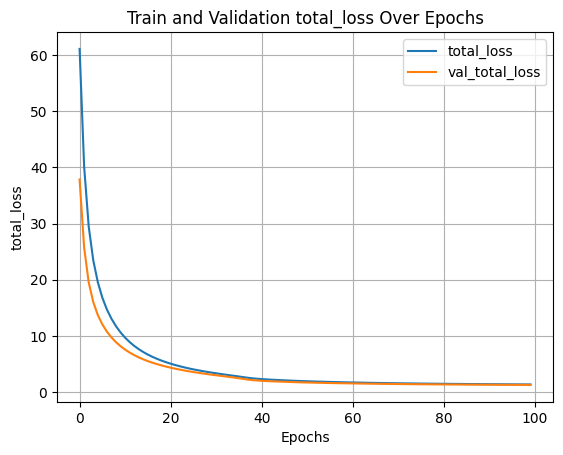

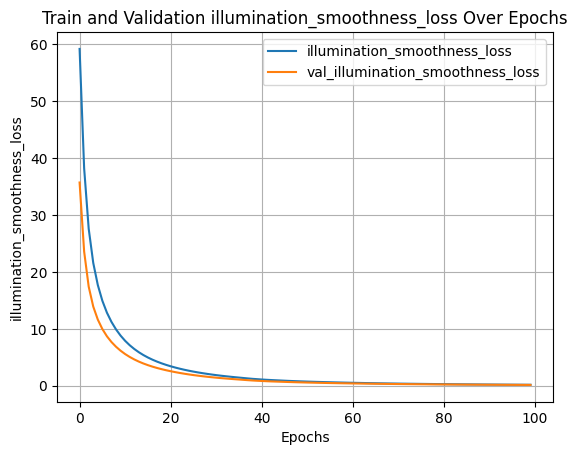

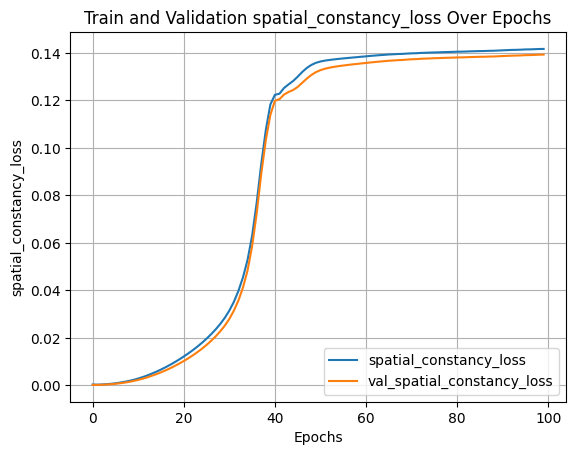

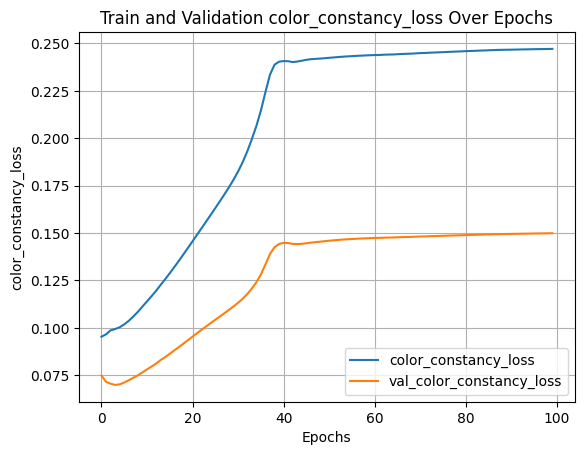

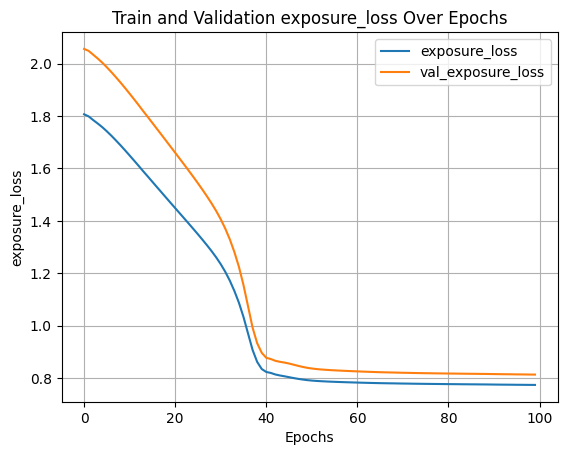

In [16]:
ourModel = ZeroDCE()
ourModel.compile(learning_rate = 1e-4)
history = ourModel.fit(train_dataset, validation_data = val_dataset, epochs = 100)


def plot_result(item):
    plt.plot(history.history[item], label = item)
    plt.plot(history.history["val_" + item], label = "val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title(f"Train and Validation {item} Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

Inference that we are getting, i.e, the final product

In [58]:
# loaded_model = ZeroDCE()

# # Load the weights into the model
# loaded_model.load_weights("C:\\mycode\\python\\Samsung Prism\\image_clarifyer_model1.h5")

def plot_results(images, titles, figure_size = (12, 12)):
    fig = plt.figure(figsize = figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i+1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

def resize_image(image, target_size=(256, 256)):
    """Resize the image to the target size."""
    return image.resize(target_size, Image.LANCZOS)  # Use LANCZOS for high-quality downsampling

def infer(original_image):
    # Store the original size of the image
    original_size = original_image.size

    # Resize the original image to a smaller size to avoid OOM error
    resized_image = resize_image(original_image, target_size=(1024, 1024))

    # Convert the resized image to an array
    image = keras.preprocessing.image.img_to_array(resized_image)
    image = image.astype("float32") / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Run the model on the input image
    output_image = ourModel(image)  # Use this when actually running the code

    # Process the output image
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())

    # Resize the output image back to the original size
    output_image = output_image.resize(original_size, Image.LANCZOS)  # Resize back to original dimensions

    return output_image

Inference on Test Images: This is where we compare the test images with the output they are supposed to have.

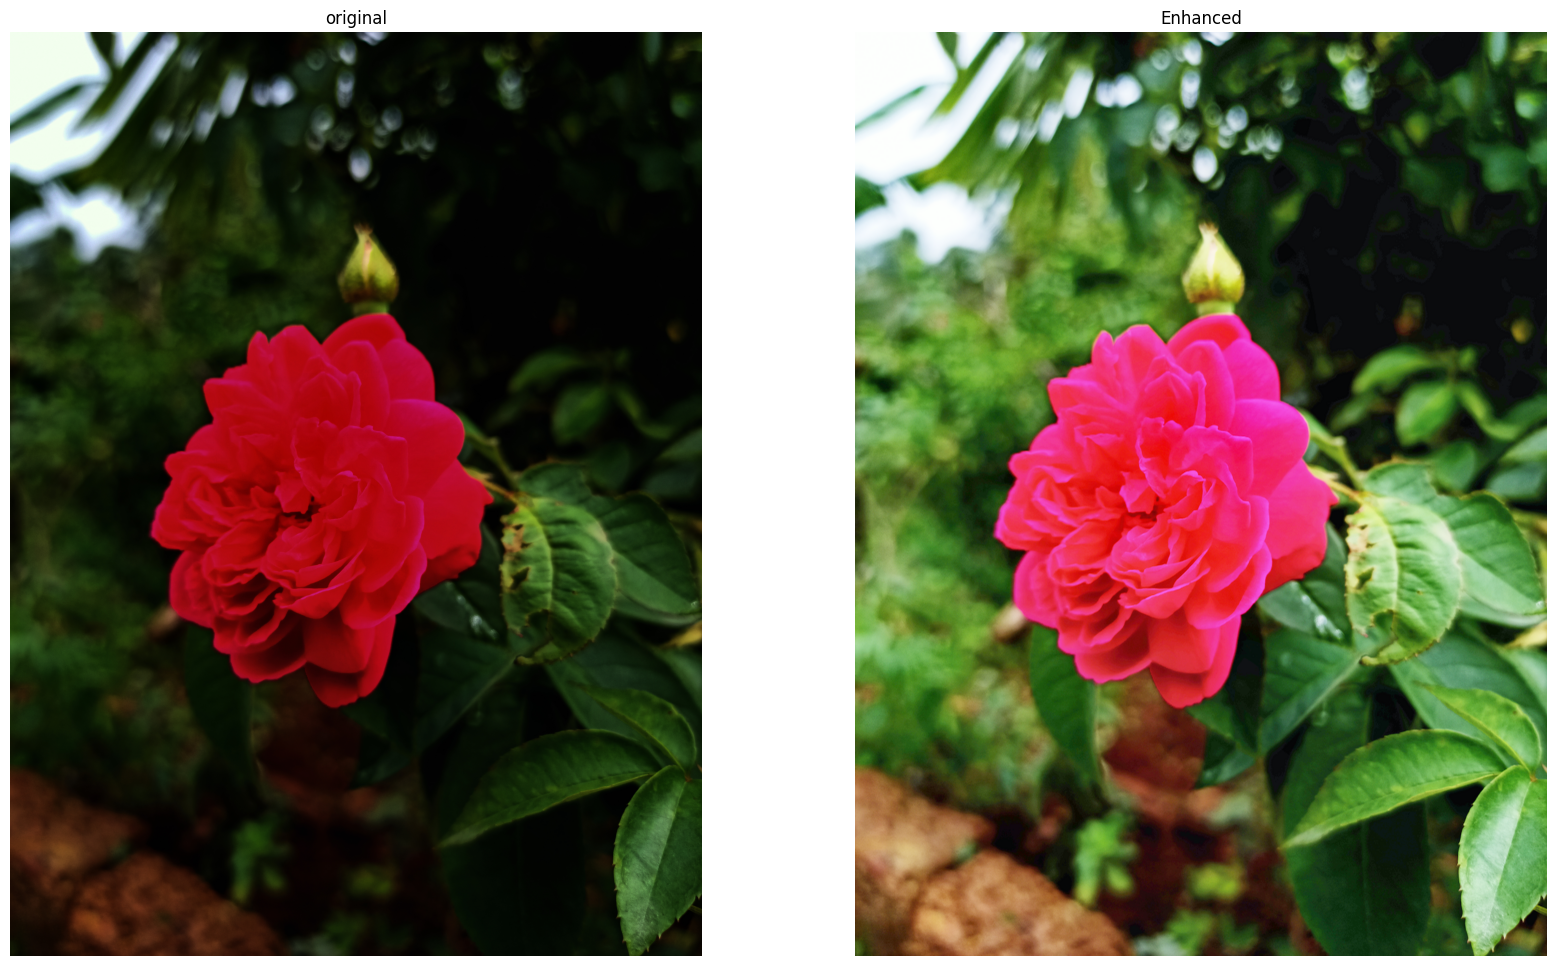

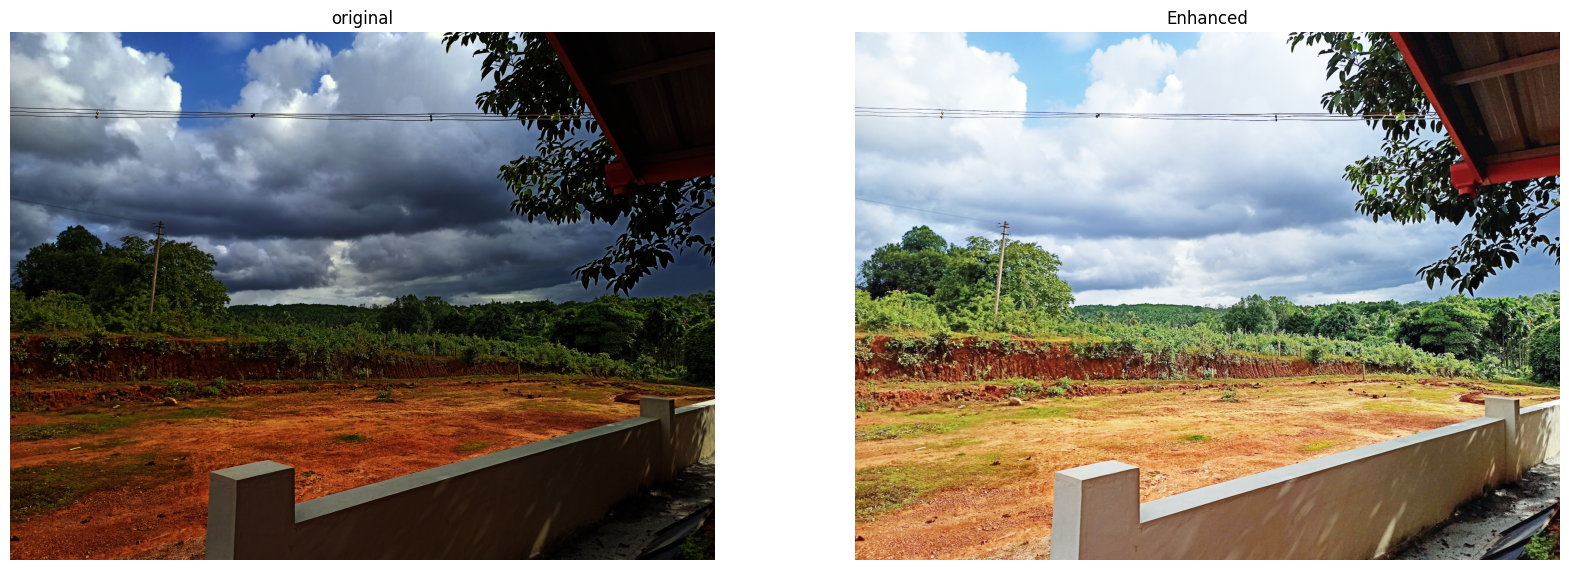

In [57]:
# test_bright_light_images = sorted(glob("./All Datasets/Dark And Bright Dataset/bright/*"),
#                                 key=lambda x: int(re.search(r'\d+', x).group()))[:]
for i, val_image_file in enumerate(test_low_light_images):
  if i < 2:
    original_image = Image.open(val_image_file)
    enhanced_image = infer(original_image)
    plot_results(
        # [original_image, ImageOps.autoconstrast(original_image), enhanced_image],
        [original_image, enhanced_image],
        ["original", "Enhanced"],
        (20, 12,),
    )

Save the Model

In [36]:
# ourModel.save("./image_clarifyer_model3.h5")
# ourModel.save("./image_clarifyer_model3.h5", save_format='h5')
ourModel.save('./image_clarifyer_model3.keras')